<a href="https://colab.research.google.com/github/joelsimonoff/127-final-project/blob/master/visualizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE127 Adversarial Example Visualizer

By Joel Simonoff, Arjun Sripathy, Matteo Ciccozzi 

_Completed as part of the UC Berkeley EE 127 final project._

## Summary

This notebook is designed to provide more insight around adversarial examples. We use a technique known as saliency mapping that allows you to visualize how differently models percieve adversarially perturbed images from normal images.

In order to provide the best visualization we needed to make the following changes From the initial project notebook:

- **Model:** MLP with Relu --> ResNet34. We went with ResNet34 because its one of the largest networks that will still run this visualization on a CPU, but still better to use the Google Colab GPUs.
- **Adversary:** FGSM --> PGD (If you are not familiar with PGD we recommend this amazing blog post: https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3)

Attributions:

- ResNets (great read to learn more about residual networks): https://arxiv.org/pdf/1512.03385.pdf
- Pretrained ResNet34 checkpoint and model code: https://github.com/VectorInstitute/gram-ood-detection
- Projected Gradient Descent Code: grabbed boiler plate code.
- Saliency Mapping Algorithm: https://arxiv.org/pdf/1906.03499.pdf

## Configure Notebook

- Imports
- Specify Cuda Device
- Download Model Checkpoints

In [0]:
import torchvision.datasets as dset
import torchvision.transforms as trn
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [0]:
torch.cuda.set_device(0)

In [113]:
!wget https://github.com/joelsimonoff/127-final-project/blob/master/ckpts/resnet_cifar10.pth?raw=true

--2020-05-04 03:15:12--  https://github.com/joelsimonoff/127-final-project/blob/master/ckpts/resnet_cifar10.pth?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/joelsimonoff/127-final-project/raw/master/ckpts/resnet_cifar10.pth [following]
--2020-05-04 03:15:12--  https://github.com/joelsimonoff/127-final-project/raw/master/ckpts/resnet_cifar10.pth
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/joelsimonoff/127-final-project/master/ckpts/resnet_cifar10.pth [following]
--2020-05-04 03:15:12--  https://raw.githubusercontent.com/joelsimonoff/127-final-project/master/ckpts/resnet_cifar10.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubuserconte

## Preprocess Model, Dataset, and Adversary

### Define Model

_Attribution: Code and checkpoint from https://github.com/VectorInstitute/gram-ood-detection | ResNet architecture from https://arxiv.org/pdf/1512.03385.pdf_

In [114]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
    
    def forward(self, x):
        t = self.conv1(x)
        out = F.relu(self.bn1(t))
        t = self.conv2(out)
        out = self.bn2(self.conv2(out))
        t = self.shortcut(x)
        out += t
        out = F.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3,64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        
        self.collecting = False
    
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        y = self.linear(out)
        return y
    
    def load(self, path="resnet_cifar10.pth?raw=true"):
        tm = torch.load(path,map_location="cpu")        
        self.load_state_dict(tm)


net = ResNet(BasicBlock, [3,4,6,3], num_classes=10)
net.load()
net.cuda()
net.eval()
print("Done")

Done


### Load Dataset

In [115]:
data = list(torch.utils.data.DataLoader(
        dset.CIFAR10('./data', 
                     train=False, 
                     transform=trn.Compose([trn.ToTensor()]), 
                     download=True),
        batch_size=1, shuffle=False))

Files already downloaded and verified


In [0]:
batch_size = 128

normalize = trn.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
inv_normalize = trn.Normalize((-0.4914/.2023, -0.4822/.1994, -0.4465/.2010), (1/0.2023, 1/0.1994, 1/0.2010))


transform_test = trn.Compose([
        trn.CenterCrop(size=(32, 32)),
        trn.ToTensor(),
    ])

test_loader = torch.utils.data.DataLoader(
    dset.CIFAR10('data', train=False, transform=transform_test),
    batch_size=batch_size)

def norm_batch(bx):
  return torch.stack([normalize(x) for x in bx])

def inv_norm_batch(bx):
  return torch.stack([inv_normalize(x) for x in bx])

class_names = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])
tl = iter(test_loader)
images, labels = tl.next()

### Visualize Cifar10

We printed out some CIFAR images to build intuition for the dataset.

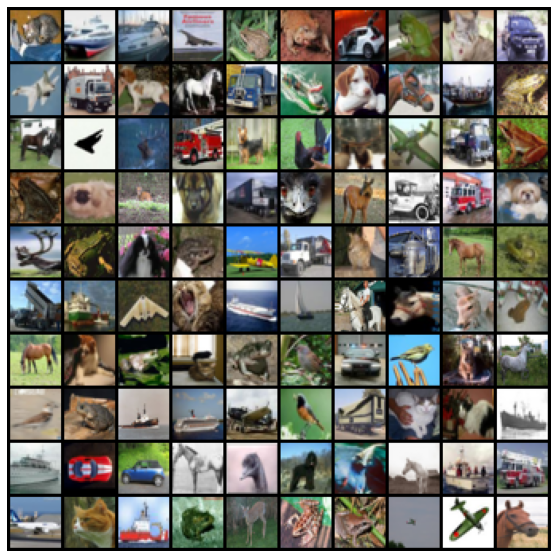

In [128]:
plt.figure(figsize=(10, 10))
plt.imshow(torchvision.utils.make_grid(images[:100], nrow=10).permute(1, 2, 0))
plt.axis('off')
plt.show()

### Define Attacker

_We highly reccommend this blog post to familiarize yourself with PGD: https://towardsdatascience.com/know-your-enemy-7f7c5038bdf3._

In [0]:
class PGD(nn.Module):
    def __init__(self, epsilon=8./255, num_steps=10, step_size=2./255, verbose=False, normalize=norm_batch):
        super().__init__()
        self.epsilon = epsilon
        self.num_steps = num_steps
        self.step_size = step_size
        self.verbose = verbose
        self.normalize = normalize

    def forward(self, model, bx, by):
        """
        :param model: the classifier's forward method
        :param bx: batch of images
        :param by: true labels
        :return: perturbed batch of images
        """
        adv_bx = bx.detach()
        adv_bx += torch.zeros_like(adv_bx).uniform_(-self.epsilon, self.epsilon)
        
        for i in range(self.num_steps):
            adv_bx.requires_grad_()
            
            with torch.enable_grad():
                logits = model(self.normalize(adv_bx))
                cent_loss = F.cross_entropy(logits, by, reduction='mean')
                loss = cent_loss
                if self.verbose:
                    print("Step: {}, Cross Entropy: {}".format(i, cent_loss))
                    
            grad = torch.autograd.grad(loss, adv_bx, only_inputs=True)[0]
            adv_bx = adv_bx.detach() + self.step_size * torch.sign(grad.detach())
            adv_bx = torch.min(torch.max(adv_bx, bx - self.epsilon), bx + self.epsilon).clamp(0, 1)
            
        return adv_bx

## Visualization 1: Perturbing Cifar10 Images with PGD

We encourage readers to play around with the PGD hyperparameters (epsilon, num_steps, step_size). We left hyperparameters in terms of some value divided by 255, because it is more intuitive to think of epsilon as `8/255` instead `0.031`. Additionally, note that the epsilon required for attacking a ResNet34 is much lower than that required for the MLP in the initial notebook.

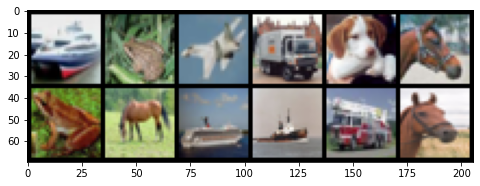

Actual Class Names:
 ['ship' 'frog' 'airplane' 'truck' 'dog' 'horse' 'frog' 'horse' 'ship'
 'ship' 'truck' 'horse']

––– Adversarially Perturbing Images –––
With Params: epsilon=8./255, num_steps=10, step_size=2./255

Step: 0, Cross Entropy: 0.004653453826904297
Step: 1, Cross Entropy: 4.207391262054443
Step: 2, Cross Entropy: 8.00178050994873
Step: 3, Cross Entropy: 11.509615898132324
Step: 4, Cross Entropy: 13.34969711303711
Step: 5, Cross Entropy: 14.626797676086426
Step: 6, Cross Entropy: 15.648090362548828
Step: 7, Cross Entropy: 16.285566329956055
Step: 8, Cross Entropy: 17.028669357299805
Step: 9, Cross Entropy: 17.372343063354492

Adversarial Perturbed Images:


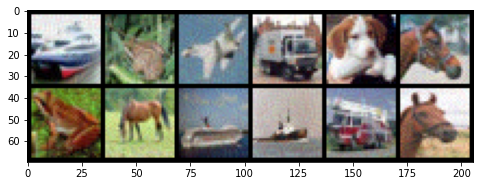

Actual Class: ship != Predicted Class: automobile
Actual Class: frog != Predicted Class: deer
Actual Class: airplane != Predicted Class: deer
Actual Class: truck != Predicted Class: ship
Actual Class: dog != Predicted Class: horse
Actual Class: horse != Predicted Class: cat
Actual Class: frog != Predicted Class: bird
Actual Class: horse != Predicted Class: dog
Actual Class: ship != Predicted Class: deer
Actual Class: ship != Predicted Class: deer
Actual Class: truck != Predicted Class: ship
Actual Class: horse != Predicted Class: bird


In [157]:
def vis_batch(bxs, nrow=6, size=(8, 24)):
  plt.figure(figsize=(size))
  plt.imshow(torchvision.utils.make_grid(bxs, nrow=nrow).permute(1, 2, 0))
  plt.show()

image_idxs = [1, 4, 10, 11, 16, 17, 29, 60, 73, 72, 89, 99]
bxs = images[image_idxs]
bys = labels[image_idxs]

vis_batch(bxs)
print("Actual Class Names:\n", class_names[bys])

print("\n––– Adversarially Perturbing Images –––\nWith Params: epsilon=8./255, num_steps=10, step_size=2./255\n")

# Change PGD hyperparameters to see how different params affect the attack.
attacker = PGD(epsilon=8./255, 
               num_steps=10, 
               step_size=2./255, 
               verbose=True)
advs_bx = attacker(net, bxs.cuda(), bys.cuda())

print("\nAdversarial Perturbed Images:")
preds = torch.max(net(norm_batch(advs_bx)), dim=1)[1]
vis_batch(advs_bx.cpu())

for i in range(len(bys)):
  
  if class_names[bys][i] == class_names[preds.cpu()][i]:
    mod = "=="
  else:
    mod = "!="
    
  print("Actual Class: {} {} Predicted Class: {}".format(class_names[bys][i], mod, class_names[preds.cpu()][i]))

## Visualization 2: Saliency Mapping

**In this visualization we read the mind of our model and tell you exactly which parts of the image it is uses to classify the image.** We use a generate matrices called saliency map, where each element at index (i,j) corresponds to the importance of the pixel in row i, column j of the image. The saliency map will tell us which pixels are most important for the classification decision.

_Based on technique from: https://arxiv.org/pdf/1906.03499.pdf_

In [0]:
def calculate_saliency_map(img, h, w, fx, pred):
    saliency_map = np.zeros((h, w))
    mask = torch.ones((h, w, 3)).cuda()
    
    for i in range(h):
        for j in range(w): 
            mask[i][j] = torch.zeros(3)
            out = net((img * mask).permute(2, 0, 1).unsqueeze(0).cuda())
            mask[i][j] = torch.ones(3)
            saliency_map[i][j] = fx - out[0][pred]
                        
    return saliency_map

def norm(sm):
    return (sm - sm.min())/(sm.max() - sm.min())

def saliency_maps_for_imgs(attacker, img, label):
    _, h, w = img[0].shape

    out = net(norm_batch(img).cuda()).data
    pred = torch.argmax(out).item()
    fx = out[0][pred]
    assert label[0] == pred
    
    adv_img = attacker(net, img.cuda(), torch.tensor([pred]).cuda())
    out_adv = net(norm_batch(adv_img).cuda()).data
    pred_adv = torch.argmax(out_adv).item()
    fx_adv = out_adv[0][pred_adv]
    
    assert pred_adv != pred
    
    sm = norm(calculate_saliency_map(img[0].permute(1, 2, 0), h, w, fx, pred))
    sm_adv = norm(calculate_saliency_map(adv_img[0].permute(1, 2, 0), h, w, fx_adv, pred_adv))
    
    return sm, sm_adv, adv_img

### Compute Saliency Maps

In [168]:
image_idxs = [1, 4, 10, 11, 16, 17, 29, 60, 73, 72, 89, 99]
bxs = images[image_idxs]
bys = labels[image_idxs]

saliency_maps = []
advs_bx_maps = []

adversary = PGD(epsilon=8./255, num_steps=10, step_size=2./255, verbose=False)
for i in tqdm(range(len(bxs))):
  sm, sm_adv, adv_img = saliency_maps_for_imgs(adversary.cuda(),
                                               bxs[i:i+1].cuda(), bys[i:i+1].cuda())
  saliency_maps.append((sm, sm_adv))
  advs_bx_maps.append(adv_img.cpu())

In [0]:
def vis_batch_heatmap(bxs, nrow=6, size=(8, 24)):
  plt.figure(figsize=(size))
  ax = plt.gca()
  im = ax.imshow(torchvision.utils.make_grid(bxs, 
                                             nrow=nrow, 
                                             normalize=True, 
                                             scale_each=True)[0], cmap="hot")

  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="3%", pad=0.05)

  plt.colorbar(im, cax=cax)

  plt.show()

sms = [torch.tensor(m[0]).unsqueeze(0) for m in saliency_maps]
sms_img = [torch.tensor(m[0]) * advs_bx_maps[i][0].cpu() for i, m in enumerate(saliency_maps)]

sms_adv = [torch.tensor(m[1]).unsqueeze(0) for m in saliency_maps]
sms_adv_img = [torch.tensor(m[1]) * advs_bx_maps[i][0].cpu() for i, m in enumerate(saliency_maps)]

advs_imgs = torch.stack(advs_bx_maps).squeeze(1).cpu()

### Regular Saliency Maps

**What To Look For**

When you look at an image often times you'll fixate on the most important parts and not examine the background. The same is true for most computer vision models, they work best when they can fixate on only the most important features. In fact, the task of classifying images implicitly includes the task of identifying the important object. Therefore, we should expect the saliency map to highlight key features in the target such as: edges, key texture points, etc. 

_It may be useful for the reader to consider other important features you might want a model to consider._

Original Images:


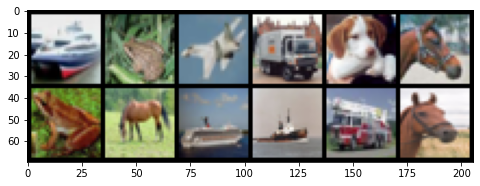

Saliency Maps:


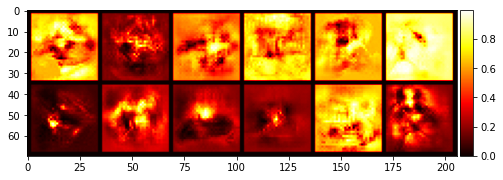

Saliency Map Overlayed On Images:


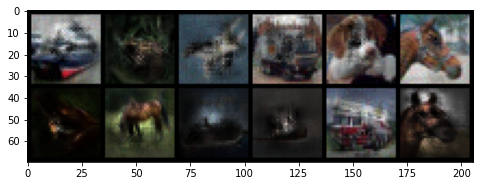

In [254]:
print("Original Images:")
vis_batch(bxs)

print("Saliency Maps:")
vis_batch_heatmap(sms)

print("Saliency Map Overlayed On Images:")
vis_batch(sms_img)

### Adversarial Image Saliency Maps

**What To Look For**

Since adversarial examples are designed to "trick" the model, they tend to "distract" the model from fixating on the target object. Therefore, we expect the saliency maps to be distinctly different from the normal saliency map. These saliency maps should focus on the background.

Adversarial Perturbed Images:


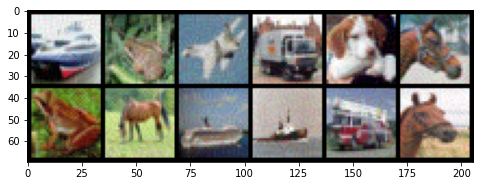

Saliency Maps:


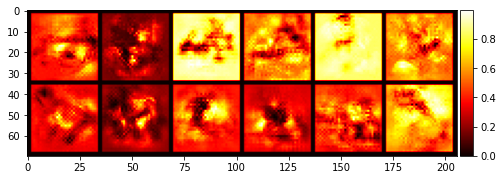

Saliency Map Overlayed On Images:


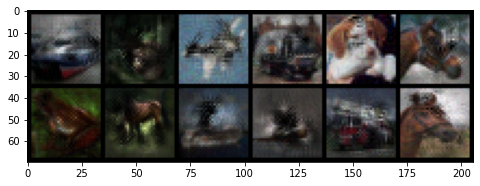

In [253]:
print("Adversarial Perturbed Images:")
vis_batch(advs_imgs)

print("Saliency Maps:")
vis_batch_heatmap(sms_adv)

print("Saliency Map Overlayed On Images:")
vis_batch(sms_adv_img)